In [5]:
%matplotlib inline
import os as os
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# visualizations and data cleaning
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
from IPython import display
import urllib.request

# peak finding
import scipy
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
from scipy import optimize
from scipy import signal
from ipywidgets import interact

# file reader
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

In [6]:
## Set google colab directory

from google.colab import output
output.enable_custom_widget_manager()

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd .../g2_correlation ## Change directory to location of files

In [8]:
## Set global matplotlib plotting parameters

mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'font.size': 20})
mpl.rcParams['font.family'] = 'serif'

In [10]:
with open('g2_data.txt','r') as file_handle:
    raw_data = file_handle.readlines()

In [12]:
lookup = 'Curve#  2'

with open('g2_data.txt') as myFile:
    for line_num, line in enumerate(myFile, 1):
        if lookup in line:
            print('Found at line:', line_num)
            break

Found at line: 131331


In [13]:
## Lowpass filter

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

order = 6     ## Order of filter
fs = 30.0     ## Sample rate, Hz
cutoff = 2    ## Desired cutoff frequency of the filter in Hz

b, a = butter_lowpass(cutoff, fs, order)

In [14]:
nbins = 65536                     ## No. of time bins - get from .phu file
resolution = 2.56*10**-10         ## Time resolution - get from .phu file
bkg = 6                           ## Background level (here it was selected visually)

t_tot = resolution*nbins*10**9    ## In ns

counts = raw_data[line_num+3:line_num+3+nbins-1]
counts_list_unfiltered = [int(sub.split('\n')[0]) for sub in counts]

counts_list = butter_lowpass_filter(counts_list_unfiltered, cutoff, fs, order)
counts_list = [i - bkg for i in counts_list]    ## Subtract background

t_list = np.linspace(0,t_tot,nbins-1)

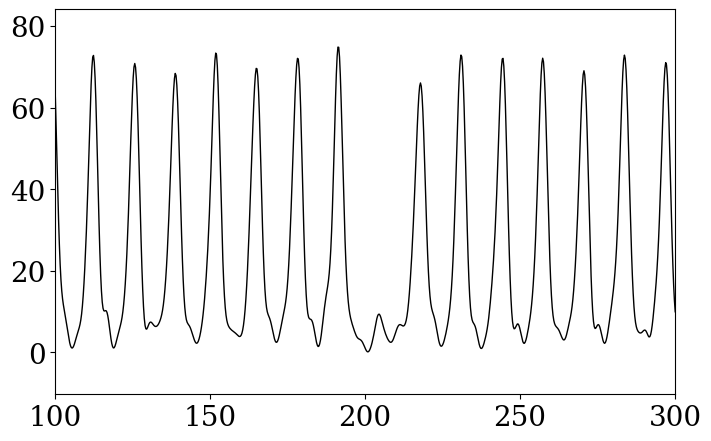

In [15]:
fig, ax = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(8)

ax.plot(t_list,counts_list,'k',linewidth=1)
ax.set_xlim(100,300)

plt.show()

## Set t=0

In [16]:
## Find t0 (visually it is the max between t=200 and t=210)

t_min = 200
t_max = 210

indices = [idx for idx,val in enumerate(t_list) if t_min < val < t_max]

y_range = []
for idx in indices:
  y_range.append(counts_list[idx])

t0_index = counts_list.index(max(y_range))
t0 = t_list[t0_index]
counts_t0 = counts_list[t0_index]

t0_list = [t-t0 for t in t_list]

## Truncate data to few peaks

In [17]:
t0_min = -100
t0_max = 100

indices = [idx for idx,val in enumerate(t0_list) if t0_min < val < t0_max]

trunc_counts_list = [counts_list[i] for i in indices]
trunc_t0_list = [t for t in t0_list if t0_min <= t <= t0_max]

## Peak finding

In [18]:
peaks_t_list = []
peaks_counts_list = []

height = 8

peaks_id, _ = scipy.signal.find_peaks(trunc_counts_list,
                                      prominence=1,
                                      distance=50,
                                      height=height,
                                      width=10,
                                      wlen = None,
                                      rel_height=0.5,
                                      plateau_size=None)

peaks_id = peaks_id.tolist()

for i in peaks_id:
  peaks_t_list.append(trunc_t0_list[i])
  peaks_counts_list.append(trunc_counts_list[i])

In [ ]:
## Only if t=0 peak is so small that it is not detected by peak finder
'''

## Add pulse at t=0

zero_id = trunc_t0_list.index(0)

peaks_t_list.append(trunc_t0_list[zero_id])
peaks_counts_list.append(trunc_counts_list[zero_id])
peaks_id.append(zero_id)

## Sort lists

peaks_counts_list = [x for _,x in sorted(zip(peaks_t_list,peaks_counts_list))]
peaks_id = [x for _,x in sorted(zip(peaks_t_list,peaks_id))]
peaks_t_list = np.sort(peaks_t_list)'''

'\n\n## Add pulse at t=0\n\nzero_id = trunc_t0_list.index(0)\n\npeaks_t_list.append(trunc_t0_list[zero_id])\npeaks_counts_list.append(trunc_counts_list[zero_id])\npeaks_id.append(zero_id)\n\n## Sort lists\n\npeaks_counts_list = [x for _,x in sorted(zip(peaks_t_list,peaks_counts_list))]\npeaks_id = [x for _,x in sorted(zip(peaks_t_list,peaks_id))]\npeaks_t_list = np.sort(peaks_t_list)'

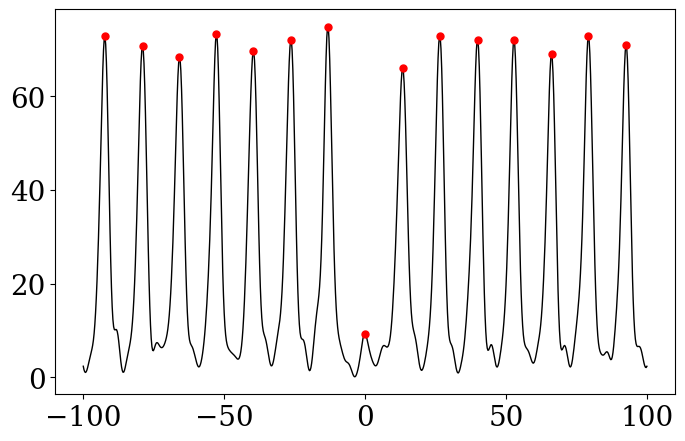

In [19]:
## Plot curve with peaks to make sure it is working properly

fig, ax = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(8)

ax.plot(trunc_t0_list,trunc_counts_list,'k',linewidth=1)
ax.plot(peaks_t_list,peaks_counts_list,"ro", markersize=5)

plt.show()

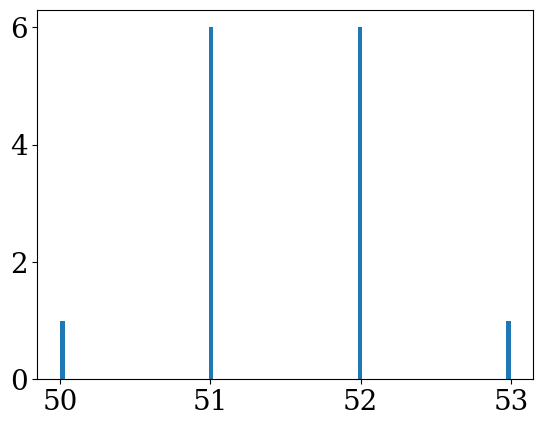

In [20]:
## Find number of time bins between 2 peaks

diff_list = np.diff(peaks_id)
counts, bins, _ = plt.hist(diff_list, bins=100)

In [21]:
nbins_pulse = 51            ## Distance between peaks from histogram in number of time bins
integration_width = 25      ## No. of time bins to choose in a peak for integration

peaks_id_bins = []          ## Carries index of each data point within the integration width around the center of a peak
peaks_profile_bins = []     ## Carries counts of each data point within the integration width around the center of a peak

for i in peaks_id:
  id_single_peak = np.linspace(i-(integration_width-1)/2,i+(integration_width-1)/2,integration_width)
  peaks_id_bins.append(id_single_peak.tolist())

for peak_num in range(len(peaks_id)):
  peak_id_list = peaks_id_bins[peak_num]
  peak_range_list = []
  for id in peak_id_list:
    peak_range_list.append(trunc_counts_list[int(id)])
  peaks_profile_bins.append(peak_range_list)

In [22]:
n_pulses = 11               ## No. of pulses you want to consider

middle = len(peaks_id)//2
n_peaks_bins = [peaks_profile_bins[i] for i in range(middle - n_pulses//2, middle + (n_pulses//2) + 1)]


## Integrate the peaks within the integration_width
integrated_peaks = []

for i in range(n_pulses):
  integrated_peaks.append(sum(n_peaks_bins[i]))


## Normalize the data
norm_factor = np.mean(integrated_peaks[:(n_pulses//2)] + integrated_peaks[(n_pulses//2)+1:])
normalized_peaks = [peak/norm_factor for peak in integrated_peaks]

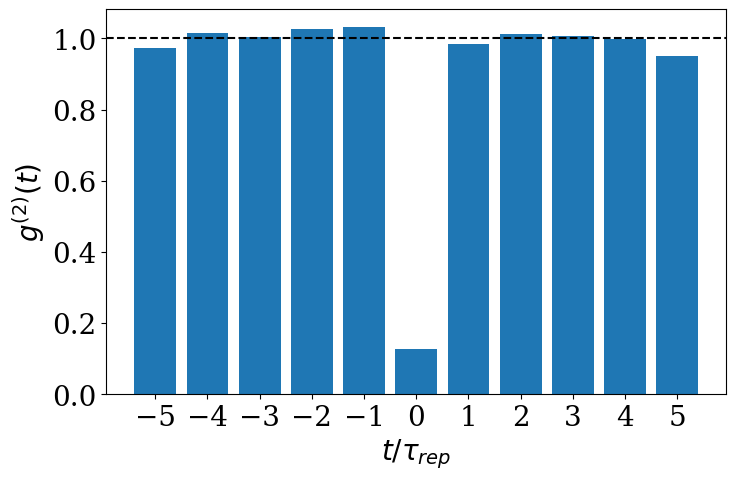

In [23]:
t_axis = np.linspace(-n_pulses//2+1, n_pulses//2, n_pulses).tolist()

fig, ax = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(8)

plt.axhline(y=1, color='k', linestyle='--')
ax.bar(t_axis,normalized_peaks)
ax.set_ylabel('$g^{(2)}(t)$')
ax.set_xlabel(r'$t/\tau_{rep}$')      ## Tau_rep is the time between two pulses
ax.set_xticks(t_axis)